# Часть 1. Теория

Реализуйте `kernel SVM` с ипользованием пакета `optimize` (как было на практике) с использованием полиномиального ядра. Продемонстрируйте результаты, сравните с библиотечным вариантом, на наборе данных типа концентрических окружностей

In [ ]:
import numpy as np
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Генерация данных
n_samples = 300
X, y = make_circles(n_samples=n_samples, factor=0.5, noise=0.1, random_state=42)
y = np.where(y == 0, -1, 1)  # Преобразуем метки в {-1, 1}
kernel_dim = 3
pd.DataFrame(y).value_counts()

0 
-1    150
 1    150
Name: count, dtype: int64

In [ ]:
# X1111, y1111 = make_circles(n_samples=n_samples, factor=0.5, noise=0.1, random_state=42)
# X == X1111, y == y1111

Text(0, 0.5, '2-ая фича')

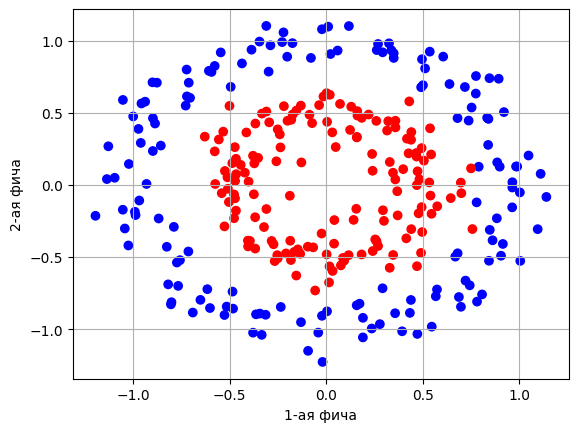

In [ ]:
plt.scatter(X[:,0], X[:,1],c = list(map(lambda x: 'red' if x == 1 else 'blue',y)))
plt.grid()
plt.xlabel('1-ая фича')
plt.ylabel('2-ая фича')

In [ ]:
# Полиномиальное ядро
def polynomial_kernel(x1, x2, c=1, d=2):
    return (np.dot(x1, x2) + c) ** d

In [ ]:
def get_target_function(alpha, X, y):
    n = len(X)
    K = np.array([[polynomial_kernel(X[i], X[j]) for j in range(n)] for i in range(n)])
    # Вычисляем LL без вложенных циклов
    LL = np.sum(alpha[:, None] * alpha[None, :] * y[:, None] * y[None, :] * K)
    # Вычисляем L
    L = -np.sum(alpha) + 0.5 * LL
    return L

def get_constraints(params, y):
    return params @ y

def train_svm_soft_margin(params, X, y, C=1):
    """
    Обучает линейный SVM с использованием scipy.optimize.minimize.

    Параметры:
    - params (np.ndarray): Вектор параметров [lmbd_0, lmbd_1, lmbd_2, ..., lmbd_n].
    - X (np.ndarray): Матрица признаков размерностью (n_samples, n_features).
    - y (np.ndarray): Вектор меток размерностью (n_samples,).
    - C (float): Значение параметра регуляризации

    Возвращает:
    - dict: Результаты оптимизации (результат функции minimize)
    """
    # Определение ограничений lambda_i >= 0
    bounds = [(0,C) for i in range(n_samples)]
    constraints = ({'type': 'eq', 'fun': lambda x1: get_constraints(x1,y)})
    result = minimize(get_target_function, params, args=(X, y), bounds=bounds, constraints=constraints, callback=track_progress)
    return result

# Функция обратного вызова для отслеживания прогресса
def track_progress(params):
    time__ = time.time()
    current_value = get_target_function(params, X, y)
    # Current parameters: {params},
    print(f"Current target function value: {current_value}, время выполнения {time__ - start_time} с")

In [ ]:
np.random.seed(42)
C = 1
params = np.random.uniform(size = (X.shape[0]))
params.shape

(300,)

In [ ]:
import time
start_time = time.time()
final_params = train_svm_soft_margin(params, X, y, C).x

Current target function value: 48.37182347054405, время выполнения 34.033674240112305 с
Current target function value: 426.1042110362222, время выполнения 66.42325162887573 с
Current target function value: 2463.22231042267, время выполнения 98.2343258857727 с
Current target function value: 541.8283014157022, время выполнения 130.53066635131836 с
Current target function value: -33.60735494662799, время выполнения 162.8381106853485 с
Current target function value: -36.619846630861645, время выполнения 194.93106293678284 с
Current target function value: -36.93041796795289, время выполнения 227.64900302886963 с
Current target function value: -37.620535374775706, время выполнения 263.1450970172882 с
Current target function value: -37.74834424438704, время выполнения 296.8418471813202 с
Current target function value: -37.83447654240558, время выполнения 330.86589097976685 с
Current target function value: -37.898898536113876, время выполнения 363.68709421157837 с
Current target function value

In [ ]:
final_params.shape

(300,)

In [ ]:
from copy import deepcopy
final_params_ = deepcopy(final_params)


In [ ]:
def get_hyperplane(final_params_, X, y, C):
    """
    Находит коэффициенты гиперплоскости

    Параметры:
    - final_params (np.ndarray): Вектор параметров [lmbd_0, lmbd_1, lmbd_2, ..., lmbd_n]
                                 после решения оптимизационной задачи.
    - X (np.ndarray): Матрица признаков размерностью (n_samples, n_features).
    - y (np.ndarray): Вектор меток размерностью (n_samples,).
    - C (float): Значение параметра регуляризации

    Возвращает:
    - (support_vectors, imposters, w0, w): индексы опорных векторов,
                                индексы нарушителей
                                коэффициент смещения,
                                координаты нормального вектора гиперплоскости.
    """
    final_params = deepcopy(final_params_)

    final_params[np.isclose(final_params,0)] = 0
    final_params[np.isclose(final_params,C)] = C
    support_vectors = np.where ((final_params>=0) & (final_params<=C))[0]
    imposters = np.where ((final_params<0))[0]
    w = np.sum(np.repeat(final_params*y, X.shape[1]).reshape(X.shape[0],-1) * X , axis = 0)
    w0 = w.T @ X[final_params>0][0,:] - y[final_params>0][0]
    # w0 = polynomial_kernel(w, X[final_params>0][0,:]) - y[final_params>0][0]
    return support_vectors, imposters, w0, w

support_vectors, imposters, w0, w = get_hyperplane(final_params, X, y, C)

In [ ]:
# Определение разделяющей поверхности
def predict(X, X_train, y, alpha,w0):
    n = X.shape[0]
    y_pred = np.zeros(n)

    for i in range(n):
        if i % 1000 == 0:
            print(i, end = ' ')
        for j in range(len(alpha)):
            y_pred[i] += alpha[j] * y[j] * polynomial_kernel(X[i], X_train[j])
        y_pred[i] = y_pred[i] - w0
    return y_pred

In [ ]:
# Сетка для разделяющей поверхности
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

In [ ]:
# print(grid.shape)
Z = predict(grid, X, y, final_params, w0).reshape(xx.shape)

# Построение разделяющей поверхности
# plot_decision_boundary(X, y, final_params, support_vectors)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 

In [ ]:
w0, Z.shape

(-2.004931888929014, (100, 100))

In [ ]:
Z__ = Z

In [ ]:
Z__[167//2,:]

array([-25.29520908, -24.52450414, -23.76976   , -23.03097666,
       -22.30815414, -21.60129242, -20.9103915 , -20.2354514 ,
       -19.5764721 , -18.93345361, -18.30639593, -17.69529905,
       -17.10016298, -16.52098772, -15.95777326, -15.41051961,
       -14.87922677, -14.36389473, -13.86452351, -13.38111308,
       -12.91366347, -12.46217466, -12.02664666, -11.60707947,
       -11.20347309, -10.81582751, -10.44414274, -10.08841877,
        -9.74865561,  -9.42485326,  -9.11701172,  -8.82513098,
        -8.54921105,  -8.28925193,  -8.04525361,  -7.81721611,
        -7.6051394 ,  -7.40902351,  -7.22886842,  -7.06467414,
        -6.91644067,  -6.784168  ,  -6.66785614,  -6.56750509,
        -6.48311485,  -6.41468541,  -6.36221678,  -6.32570895,
        -6.30516194,  -6.30057573,  -6.31195032,  -6.33928573,
        -6.38258194,  -6.44183896,  -6.51705678,  -6.60823541,
        -6.71537485,  -6.8384751 ,  -6.97753615,  -7.13255801,
        -7.30354068,  -7.49048415,  -7.69338843,  -7.91

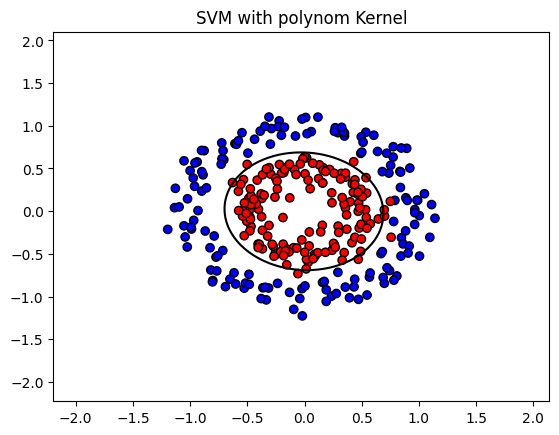

In [ ]:
# Рисуем разделяющую поверхность
# plt.contourf(xx, yy, np.sign(Z__), alpha=0.5, cmap='coolwarm')
plt.contour(xx, yy, Z__, levels=[-1], colors='black')

# plt.colorbar()
# # Отображаем данные
plt.scatter(X[:, 0], X[:, 1], c = list(map(lambda x: 'red' if x == 1 else 'blue',y)), edgecolors='k')
# plt.scatter(X[support_vectors, 0], X[support_vectors, 1], edgecolors='yellow', s=100, label='Support Vectors')
# plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=100, facecolors='none', edgecolors='k', label='Опорные векторы')
# plt.scatter(X[imposters, 0], X[imposters, 1], s=100, marker=',', label='Нарушители')
plt.title("SVM with polynom Kernel")
# plt.legend()
plt.show()


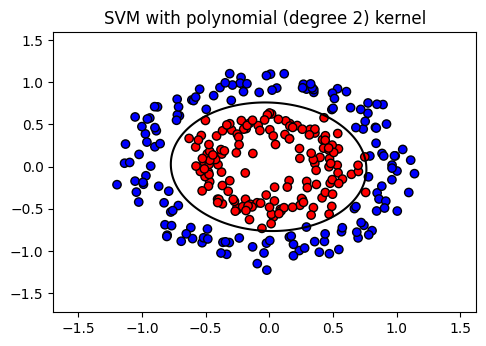

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

poly_svc = svm.SVC(kernel='poly', degree=2, C=C, probability=True, coef0 = 1, gamma=1).fit(X, y)


h = 0.02  # шаг в сетке
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Заголовки графиков
titles = ['SVM with polynomial (degree 2) kernel']

# Создаем график
plt.figure(figsize=(12, 8))

i = 0
clf = poly_svc

# Рисуем границы принятия решений на графике
plt.subplot(2, 2, i+1)
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# plt.contourf(xx, yy, Z, cmap=plt.cm.Set1, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], colors='black')
# Рисуем точки данных
plt.scatter(X[:, 0], X[:, 1], c = list(map(lambda x: 'red' if x == 1 else 'blue',y)), edgecolor='k')
plt.title(titles[i])

plt.show()


In [ ]:
Z[167//2,:]

array([-9.49375934, -9.21368618, -8.93694084, -8.66352333, -8.39343364,
       -8.12667177, -7.86323773, -7.60313151, -7.34635311, -7.09290254,
       -6.8427798 , -6.59598487, -6.35251777, -6.1123785 , -5.87556704,
       -5.64208341, -5.41192761, -5.18509963, -4.96159947, -4.74142714,
       -4.52458262, -4.31106594, -4.10087708, -3.89401604, -3.69048282,
       -3.49027743, -3.29339986, -3.09985011, -2.90962819, -2.7227341 ,
       -2.53916782, -2.35892937, -2.18201875, -2.00843594, -1.83818097,
       -1.67125381, -1.50765448, -1.34738297, -1.19043929, -1.03682343,
       -0.88653539, -0.73957518, -0.59594279, -0.45563822, -0.31866148,
       -0.18501256, -0.05469147,  0.0723018 ,  0.19596725,  0.31630487,
        0.43331467,  0.54699665,  0.6573508 ,  0.76437713,  0.86807563,
        0.96844632,  1.06548917,  1.15920421,  1.24959142,  1.3366508 ,
        1.42038237,  1.50078611,  1.57786202,  1.65161011,  1.72203038,
        1.78912282,  1.85288745,  1.91332424,  1.97043322,  2.02

# Часть 2. Детектирование аномалий на основе One-Class SVM
Рассмотрим задачу детектирование сетевых атак: Intrusion Detection. Будем использовать данные из KDD Cup 1999 Competition ( http://kdd.ics.uci.edu/databases/kddcup99/task.html). Полная база данных содержит около пяти миллионов записей о сетевых соединениях и различных типах атаках. Mы будем работать подвыборкой в 10% от оригинального датасета, отсутствие атаки обозначено как “normal”, а ее наличие — как “abnormal”.

In [ ]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

np.random.seed(0)

In [ ]:
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split

from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD as TSVD

Считаем данные:

In [ ]:
train = pd.read_csv('intrusion/train')
test = pd.read_csv('intrusion/test', delimiter = ';')
X_test = np.array(test.drop(test.columns[[0, 1, 2, 3]], axis=1))
np.save('test_np', X_test)

In [ ]:
train.head(n=10)

,0,tcp,http,SF,181,5450,0.1,0.2,0.3,0.4,...,9.1,1.00.1,0.00.6,0.11,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,210,624,0,0,0,0,...,109,1.0,0.0,0.06,0.05,0.0,0.0,0.0,0.0,normal.


В выборке метками $\{-1, 1\}$ обозначены аномальныe и нормальные наблюдения. Посмотрим на гистограмму классов:

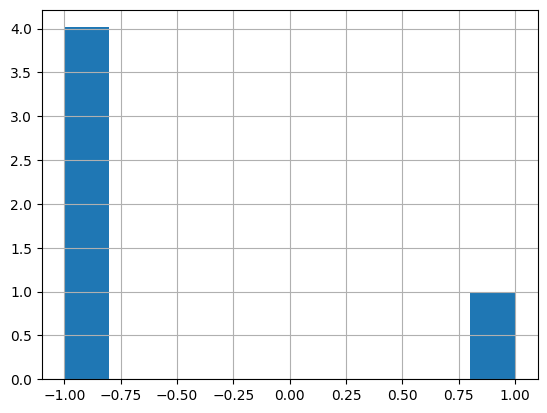

In [ ]:
y_train = (train['normal.'] == 'normal.') * 2 - 1
plt.hist(y_train, density=True);
plt.grid(True)

«Отрежем» не нужные для обучения колонки и целевую переменную.

In [ ]:
X_train = train.drop(train.columns[[0, 1, 2, 3, 41]], axis=1)
y_train = y_train

In [ ]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train_)
# X_train = pd.DataFrame(X_train, columns = X_train_.columns, index = X_train_.index)

In [ ]:
X_train

,181,5450,0.1,0.2,0.3,0.4,0.5,1,0.6,0.7,...,9,9.1,1.00.1,0.00.6,0.11,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11
0,239,486,0,0,0,0,0,1,0,0,...,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0
1,235,1337,0,0,0,0,0,1,0,0,...,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0
2,219,1337,0,0,0,0,0,1,0,0,...,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0
3,217,2032,0,0,0,0,0,1,0,0,...,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0
4,217,2032,0,0,0,0,0,1,0,0,...,59,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,310,1881,0,0,0,0,0,1,0,0,...,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0
494016,282,2286,0,0,0,0,0,1,0,0,...,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0
494017,203,1200,0,0,0,0,0,1,0,0,...,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0
494018,291,1200,0,0,0,0,0,1,0,0,...,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0


Посмотрим на признаки. Самый простой способ оценить их качество — это посчитать дисперсию:

In [ ]:
X_train.var()

181        9.765770e+11
5450       1.091644e+09
0.1        4.453072e-05
0.2        1.817249e-02
0.3        3.036300e-05
0.4        6.116857e-01
0.5        2.408584e-04
1          1.262687e-01
0.6        3.233984e+00
0.7        1.113194e-04
0.8        6.072508e-05
0.9        4.051043e+00
0.10       9.296040e-03
0.12       1.214409e-04
0.13       1.330916e-03
0.14       0.000000e+00
0.15       0.000000e+00
0.16       1.384664e-03
8          4.543170e+04
8.1        6.067489e+04
0.00       1.449456e-01
0.00.1     1.451739e-01
0.00.2     5.364954e-02
0.00.3     5.389232e-02
1.00       1.506913e-01
0.00.4     6.757756e-03
0.00.5     2.027708e-02
9          4.191872e+03
9.1        1.124453e+04
1.00.1     1.687412e-01
0.00.6     1.193758e-02
0.11       2.316586e-01
0.00.7     1.775183e-03
0.00.8     1.448513e-01
0.00.9     1.450999e-01
0.00.10    5.317162e-02
0.00.11    5.296467e-02
dtype: float64

In [ ]:
X_train.shape

(494020, 37)

Видим, что есть два константных признака. Их можно удалить:

In [ ]:
idx = np.where(X_train.var() == 0)[0]
cols = X_train.columns[idx]
X_train.drop(cols, axis=1, inplace=True)

Следующее, что можно сделать, это посмотреть попарные корреляции признаков:

<Figure size 500x500 with 0 Axes>

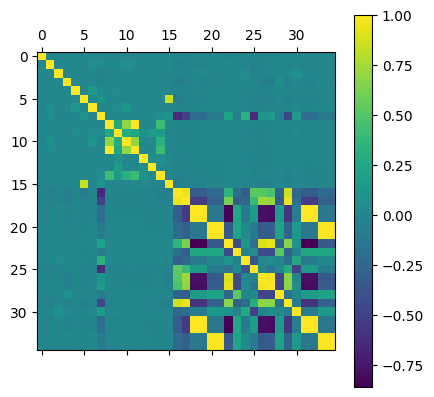

In [ ]:
plt.figure(figsize=(5,5));
plt.matshow(X_train.corr());
plt.colorbar()

Такая структура обещает эффективное снижение размерности. Почему?

Во-первых, матрица ковариаций факторизуется на 2 блока признаков, каждый из который имеет корреляцию между фичами практически только внутри себя.
Из 1-ого блока можно выкинуть 3 фичи, из 2-ого блока: существуют линейно зависимые признаки (явно прослеэивается 12 признаков, из которых можно оставить 4).

### Задание 1
Оцените с помощью `randomized SVD` количество компонент достаточных для сжатия и дальнейшего ускорения обучения. (`randomized SVD` - быстрый способ оценки количества компонент)

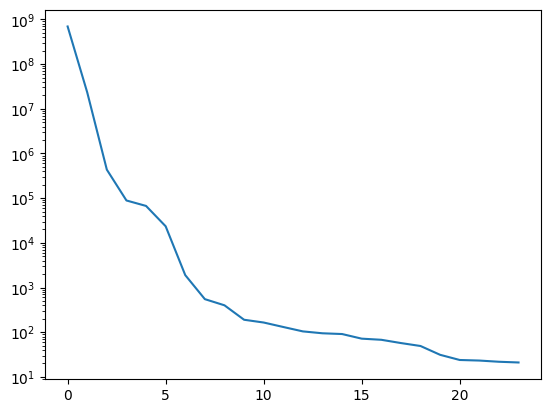

In [ ]:
from sklearn.utils.extmath import randomized_svd
X_train = np.array(X_train)
look_on_components =  X_train.shape[1] - 11
U, Sigma, VT =  randomized_svd(X_train, look_on_components)
plt.plot(Sigma);
plt.yscale('log')

### Задание 2

Выберите количество компонент для сжатия и примените **truncated SVD**

In [ ]:
from sklearn.decomposition import TruncatedSVD
model =  TruncatedSVD(n_components=17)
X_train_proj =  model.fit_transform(X_train)

### Задание 3

Проведите подбор параметров $\nu$ и $\gamma$ для модели OneClassSVM.

Подбор сразу двух параметров может быть затруднен с вычислительной точки зрения (занимает много времени на слабых ПК). В таком случае возможны два выхода:

1) Проводить раздельный подбор гиперпараматров. Сначала поиск по $\nu$, затем при оптимальном $\nu_{opt}$ провести поиск по $\gamma$

2) Уменьшить размер датасета

Поиск параметров предлагается провести в следующей области параметров:

$\nu$: [0.5,1]

$\gamma$: [0.1, 1]


In [ ]:
# количество обьектов для сокращения выборки
# перед уменьшением выборки дайте шанс обучению на полном датасете
subsample_N = 10000 #X_train_proj.shape[0] # вместо этого укажите свое N

X_subsample = X_train_proj[0:subsample_N]
y_subsample = y_train[0:subsample_N]

print(X_train_proj.shape)
print(X_subsample.shape)

(494020, 17)
(10000, 17)


In [ ]:
print(np.isnan(X_train_proj).sum())
print(np.isinf(X_train_proj).sum())

0
0


#### Проведем поиск по первому параметру $\nu$:

In [ ]:
from sklearn.svm import OneClassSVM
scores = {'accuracy_score': make_scorer(accuracy_score),}

model = OneClassSVM(kernel='poly', degree=3, coef0=0.0, \
                                tol=0.001, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

grid = {
    'nu':  np.linspace(0.01,0.99,31)
}

search = GridSearchCV(model, grid, scoring=scores,
                      n_jobs=-1, cv=2,
                      refit='accuracy_score')

search.fit(X_subsample, y_subsample)

GridSearchCV(cv=2, estimator=OneClassSVM(kernel='poly'), n_jobs=-1,
             param_grid={'nu': array([0.01      , 0.04266667, 0.07533333, 0.108     , 0.14066667,
       0.17333333, 0.206     , 0.23866667, 0.27133333, 0.304     ,
       0.33666667, 0.36933333, 0.402     , 0.43466667, 0.46733333,
       0.5       , 0.53266667, 0.56533333, 0.598     , 0.63066667,
       0.66333333, 0.696     , 0.72866667, 0.76133333, 0.794     ,
       0.82666667, 0.85933333, 0.892     , 0.92466667, 0.95733333,
       0.99      ])},
             refit='accuracy_score',
             scoring={'accuracy_score': make_scorer(accuracy_score, response_method='predict')})

#### Построим результаты валидации:

In [ ]:
 # your code here

print("nu:     ", search.cv_results_['param_nu'].data)
print("scores: ", search.cv_results_['mean_test_accuracy_score'])

nu:      [0.01       0.04266667 0.07533333 0.108      0.14066667 0.17333333
 0.206      0.23866667 0.27133333 0.304      0.33666667 0.36933333
 0.402      0.43466667 0.46733333 0.5        0.53266667 0.56533333
 0.598      0.63066667 0.66333333 0.696      0.72866667 0.76133333
 0.794      0.82666667 0.85933333 0.892      0.92466667 0.95733333
 0.99      ]
scores:  [0.6702 0.8147 0.5759 0.5876 0.6156 0.7168 0.5102 0.7101 0.4971 0.7066
 0.666  0.6721 0.6583 0.6374 0.6278 0.6112 0.5937 0.5827 0.5734 0.5544
 0.5492 0.541  0.5242 0.5061 0.4714 0.4344 0.394  0.3542 0.3122 0.2731
 0.2335]


Выберите $\nu$, обеспечивающее наибольший score на кроссвалидации, за исключением $\nu=1$, т.к. это противоречит физическому смыслу задачи

In [ ]:
best_params = search.best_params_
best_score = search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучший score: {best_score}")

Лучшие параметры: {'nu': 0.042666666666666665}
Лучший score: 0.8147


In [ ]:
# model = OneClassSVM() #kernel='poly', degree=3, coef0=0.0, \
                       #         tol=0.001, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model = OneClassSVM(kernel='poly',nu=0.0427, degree=3, coef0=0.0, \
                                tol=0.001, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

grid = {
    # 'nu':  np.linspace(0.5,0.99,31),
    'gamma':  np.linspace(0.01,0.99,31)
}

search = GridSearchCV(model, grid, scoring=scores,
                      n_jobs=-1, cv=2,
                      refit='accuracy_score')

search.fit(X_subsample, y_subsample)

# best_params_
score = search.cv_results_['mean_test_accuracy_score']



print("gamma:     ", search.cv_results_['param_gamma'].data)
print("scores: ", search.cv_results_['mean_test_accuracy_score'])

# nu = search.cv_results_['param_nu'].data
# nu_opt = nu[np.argmax(score[score < 0.8])]#.max()
# print(nu_opt)

gamma = search.cv_results_['param_gamma'].data
gamma_opt = gamma[np.argmax(score)]#.max()
print(gamma_opt)



gamma:      [0.01       0.04266667 0.07533333 0.108      0.14066667 0.17333333
 0.206      0.23866667 0.27133333 0.304      0.33666667 0.36933333
 0.402      0.43466667 0.46733333 0.5        0.53266667 0.56533333
 0.598      0.63066667 0.66333333 0.696      0.72866667 0.76133333
 0.794      0.82666667 0.85933333 0.892      0.92466667 0.95733333
 0.99      ]
scores:  [0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952
 0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952 0.952
 0.952 0.952 0.952 0.952 0.952 0.952 0.952]
0.01


Теперь необходимо подобрать $\gamma$. Оптимальнее конечно было бы подбирать сразу оба параметра, но если это невозможно для ваших ресурсов в силу вычислительной сложности, то проведите отдельный поиск $\gamma$ при найденном ранее $\nu_{opt}$.

# Задание
+ Используя кроссвалидацию, оценить качество определения аномальных наблюдений с помощью обученной модели `One-Class SVM`
+ Исследовать зависимость этого качества от параметров метода (ширина ядра, доля выбросов в модели, задаваемая параметром $\nu$)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
subsample_N = 10000 #X_train_proj.shape[0] # вместо этого укажите свое N

X_subsample = X_train_proj[0:subsample_N]
y_subsample = y_train[0:subsample_N]


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(nu=nu, gamma=gamma):
    # model = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
    model = OneClassSVM(kernel='poly', degree=3, coef0=0.0, \
                        nu=nu, gamma=gamma, \
                        tol=0.001, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
    accuracy_scores = cross_val_score(model, X_subsample,y_subsample, cv=kf, scoring=make_scorer(accuracy_score))
    return np.mean(accuracy_scores)

# Параметры для исследования
nu_values = np.linspace(0.1,0.95,10)
kernel_values = ['poly'] # 'linear',
gamma_values = np.linspace(0.1,0.99,10)


results = {}
for kernel in kernel_values:
    res = {}
    for nu in nu_values:
        for gamma in gamma_values:
            score = evaluate_model(nu=nu, gamma=gamma)
            res[(nu, gamma)] = score
    results[kernel] = res

# Выводим результаты
print('fine!')

fine!


In [ ]:
kernel_ = kernel_values[0]
nu_x = list(map(lambda x: x[0], list(results[kernel_].keys())))
gamma_y = list(map(lambda x: x[1], list(results[kernel_].keys())))
z = list(results[kernel_].values())

In [ ]:
# z

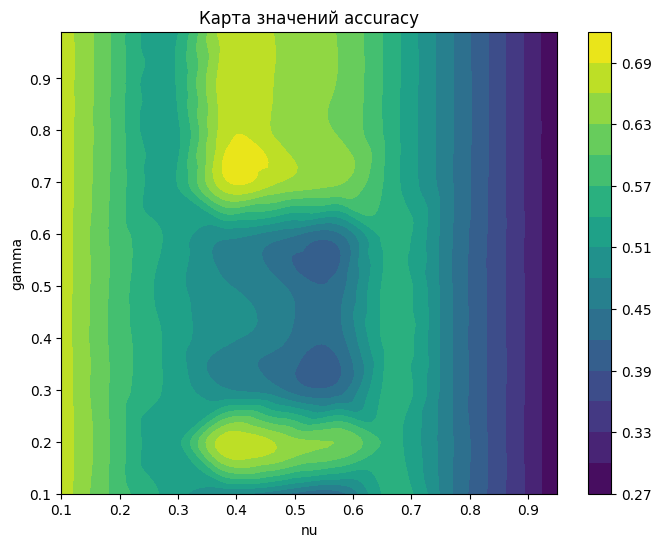

In [ ]:
from scipy.interpolate import griddata
xi = np.linspace(np.min(nu_x), np.max(nu_x), 100)
yi = np.linspace(np.min(gamma_y), np.max(gamma_y), 100)
xi, yi = np.meshgrid(xi, yi)

# Интерполяция значений z на сетке
zi = griddata((nu_x, gamma_y), z, (xi, yi), method='cubic')

# Построение карты
plt.figure(figsize=(8, 6))
contour = plt.contourf(xi, yi, zi, levels=15, cmap='viridis')
plt.colorbar(contour)
# plt.scatter(nu_x, gamma_y, color='red', label='Исходные точки')  # Отметим исходные точки
plt.title('Карта значений accuracy')
plt.xlabel('nu')
plt.ylabel('gamma')
# plt.legend()
plt.show()
